In [3]:
import numpy as np
import networkx as nx
from networkx.algorithms.dag import is_directed_acyclic_graph
from multiprocessing import Pool
import pandas as pd
import random

from typing import List

from simulated import Simulated


In [4]:
def generate_single_dag(n_variables, sdn, random_state, types ) -> nx.DiGraph:
        """
        Generates a single directed acyclic graph (DAG).
        
        Args:
            index (int): The index number for the DAG.

        Returns:
            nx.DiGraph: Generated DAG.
        """
        G = nx.DiGraph()
        edges = [(i, j) for i in range(n_variables) for j in range(i)]
        G.add_edges_from(edges)
        
        while not is_directed_acyclic_graph(G):
            # If it's not a DAG, remove a random edge
            edge_to_remove = random.choice(list(G.edges()))
            G.remove_edge(*edge_to_remove)

        for node in G.nodes:
            G.nodes[node]['bias'] = np.random.normal(loc=0, scale=1)
            G.nodes[node]['sigma'] = sdn
            G.nodes[node]['seed'] = random_state

        for edge in G.edges:
            G.edges[edge]['weight'] = np.random.uniform(low=0, high=1) #TODO: check weight implementation
            G.edges[edge]['H'] = random.choice(types) 

        return G

def update_dag(maxlags, dag: nx.DiGraph) -> nx.DiGraph:  
        """
        Updates the given DAG for a new timestep by adding past values as new nodes.
        
        Args:
            dag (nx.DiGraph): The original DAG.
            data (pd.DataFrame): The DataFrame containing past observations.
            timestep (int): The current timestep.

        Returns:
            nx.DiGraph: The updated DAG.
        """
        # Add past nodes and edges to the DAG
        past_dag = dag.copy(as_view=False)

        # Add past nodes and edges to the DAG
        for node in dag.nodes:
            for lag in range(1, maxlags + 1):
                past_node = f"{node}_t-{lag}"
                past_dag.add_node(past_node, **dag.nodes[node])  # Copy attributes from the original node
                if lag > 1: 
                    past_dag.add_edge(past_node, f"{node}_t-{lag-1}", weight=1, H='linear')
                weight = np.round(np.random.uniform(low=0, high=1), 2)
                past_dag.add_edge(past_node, node, weight=weight, H='linear')

                # Add edges from past nodes to current nodes that the original node had edges to
                for successor in dag.successors(node):
                    weight = np.round(np.random.uniform(low=0, high=1), 2)
                    past_dag.add_edge(past_node, successor, **dag.edges[node, successor])  # Copy attributes from the original edge

        return past_dag

def compute_value(value, edge_data, parent_value):
    weight = edge_data['weight'] 
    H = edge_data['H']
    if H == "linear":
        a = np.random.uniform(-1, 1, 2).reshape(2, 1)
        X = np.array([parent_value ** i for i in range(2)])    # data[node] += a0 * 1 + a1 * data[parent] 
        value += np.sum(X * a)
    elif H == "quadratic":
        a = np.random.uniform(-1, 1, 3).reshape(3, 1)
        X = np.array([parent_value ** i for i in range(3)])
        value += np.sum(X * a)
    elif H == "exponential":
        a = np.random.uniform(-1, 1)
        b = np.random.uniform(0, 1)
        value += a * np.exp(b * parent_value)
    elif H == "logarithmic": #could capture a slowing or saturating effect.
        a = np.random.uniform(-1, 1)
        b = np.random.uniform(1, 2)
        value += a * np.log(b + parent_value)
    elif H == "sigmoid": #could model a system that has a thresholding or saturating effect.
        a = np.random.uniform(-5, 5)
        b = np.random.uniform(0, 1)
        value += 1 / (1 + np.exp(-a * (parent_value - b)))
    elif H == "sinusoidal": #can model periodic effects
        a = np.random.uniform(-1, 1)
        b = np.random.uniform(0, 2 * np.pi)
        value += a * np.sin(b + parent_value)

    return value 

In [5]:
n_variables = 5
sdn = 1
random_state = 0
types = ["linear", "quadratic", "sigmoid"]
maxlags = 3
dag = generate_single_dag(n_variables, sdn, random_state, types)
updated_dag = update_dag(maxlags, dag)

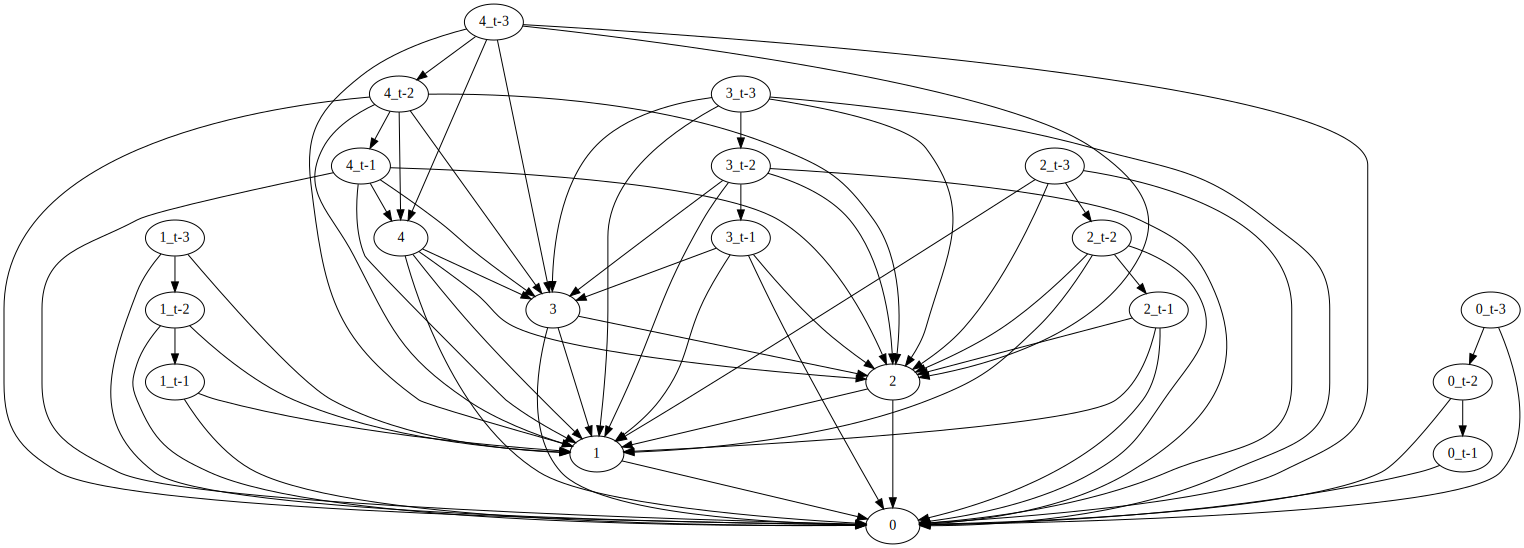

In [6]:
from graphviz import Digraph

G_dot = Digraph(engine="dot",format='png')

for node in updated_dag.nodes():
    G_dot.node(str(node))
for edge in updated_dag.edges():
    G_dot.edge(str(edge[0]), str(edge[1]))

# Render the graph in a hierarchical layout
G_dot

In [24]:
def generate_timestep_observations(dag: nx.DiGraph, data: pd.DataFrame) -> pd.DataFrame:
        """
        Generates observations for a single timestep.
        
        Args:
            dag (nx.DiGraph): The DAG for which to simulate observations.
            data (pd.DataFrame): The DataFrame containing past observations.
            timestep (int): The current timestep.

        Returns:
            pd.DataFrame: A DataFrame containing the observations.
        """
        
        #inizialize the first row of the dataframe
        current_len = len(data)
        for node in nx.topological_sort(dag):
            if f"_t-" in str(node):
                print(node)
                variable = int(str(node)[0])
                timestamp = int(str(node)[-1])
                dag.nodes[node]['value'] = data.loc[len(data) - timestamp, variable] 
            else:
                parents = list(dag.predecessors(node))
                print(data)
                print("+++++")
                print("Parents: ", parents, "Node: ", node, "Len data: ", len(data))
                bias = dag.nodes[node]['bias']
                sigma = dag.nodes[node]['sigma']
                
                data.loc[current_len, node] = 0
                for parent in parents:
                    print("Parent: ", parent, "Node: ", node, "Value: ", dag.nodes[parent]['value'])
                    edge_data = dag.edges[parent, node]
                    data.loc[current_len, node] += compute_value(bias, edge_data, dag.nodes[parent]['value'])
                data.loc[current_len, node] += np.random.normal(scale=sigma)
                dag.nodes[node]['value'] = data.loc[current_len, node]
        


In [25]:
data = pd.DataFrame(columns=dag.nodes)
data.loc[len(data)] = [1,2,3,4,5]
data.loc[len(data)] = [11,22,33,44,55]
data.loc[len(data)] = [111,222,333,444,555]
data.loc[len(data)] = [1111,2222,3333,4444,5555]

In [26]:
data

,1,0,2,3,4
0,1,2,3,4,5
1,11,22,33,44,55
2,111,222,333,444,555
3,1111,2222,3333,4444,5555


In [29]:
generate_timestep_observations(updated_dag, data)

1_t-3
0_t-3
2_t-3
3_t-3
4_t-3
1_t-2
0_t-2
2_t-2
3_t-2
4_t-2
1_t-1
0_t-1
2_t-1
3_t-1
4_t-1
              1             0             2            3            4
0  1.000000e+00  2.000000e+00  3.000000e+00     4.000000     5.000000
1  1.100000e+01  2.200000e+01  3.300000e+01    44.000000    55.000000
2  1.110000e+02  2.220000e+02  3.330000e+02   444.000000   555.000000
3  1.111000e+03  2.222000e+03  3.333000e+03  4444.000000  5555.000000
4 -1.649922e+07 -2.458101e+07 -2.855625e+07 -1728.305656 -7113.601708
+++++
Parents:  ['4_t-1', '4_t-2', '4_t-3'] Node:  4 Len data:  5
Parent:  4_t-1 Node:  4 Value:  -7113.601707990938
Parent:  4_t-2 Node:  4 Value:  5555.0
Parent:  4_t-3 Node:  4 Value:  555.0
              1             0             2            3            4
0  1.000000e+00  2.000000e+00  3.000000e+00     4.000000     5.000000
1  1.100000e+01  2.200000e+01  3.300000e+01    44.000000    55.000000
2  1.110000e+02  2.220000e+02  3.330000e+02   444.000000   555.000000
3  1.111000e+03 

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_20328\2275454799.py:85: RuntimeWarning: overflow encountered in exp
  value += 1 / (1 + np.exp(-a * (parent_value - b)))
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_20328\2275454799.py:85: RuntimeWarning: overflow encountered in exp
  value += 1 / (1 + np.exp(-a * (parent_value - b)))


In [30]:
data

,1,0,2,3,4
0,1.000000e+00,2.000000e+00,3.000000e+00,4.000000,5.000000
1,1.100000e+01,2.200000e+01,3.300000e+01,44.000000,55.000000
2,1.110000e+02,2.220000e+02,3.330000e+02,444.000000,555.000000
3,1.111000e+03,2.222000e+03,3.333000e+03,4444.000000,5555.000000
4,-1.649922e+07,-2.458101e+07,-2.855625e+07,-1728.305656,-7113.601708
5,-3.477997e+07,5.361615e+07,7.361446e+07,-1244.239804,8171.942892
